# Блок 1. Решение SQL задач

In [13]:
import pandas as pd
import pandasql as pdsql
import time
import datetime

<span style='text-decoration: underline; font-size:18px; font-family: "Impact"'>Задача 1</span>
##### Напишите sql запрос, который будет переводить сумму транзакций в usd (ccy_code = 840) с учетом того, что в таблице rates данные только за рабочие дни. Транзакции, совершенные в выходные, пересчитываются по курсу последнего рабочего дня перед праздником/выходным. Результат: Клиент, дата, сумма операций в usd.

In [175]:
Transactions = pd.DataFrame({'Client_id': [111, 123, 161], 'Report_date': ['2016-12-30', '2017-01-01', '2017-01-07'], 'Txn_amount': [77700, 50000, 20202]});
Rates = pd.DataFrame({'Report_date': ['2016-12-30', '2017-01-01', '2017-01-06', '2017-01-08'],  'Ccy_code': [840, 840, 840, 840], 'CCy_rate': [60.58, 61.61, 61.00, 61.01]});
Transactions['Report_date'] = Transactions['Report_date'].apply(lambda date_string: time.mktime(time.strptime(date_string, '%Y-%m-%d')))
Rates['Report_date'] = Rates['Report_date'].apply(lambda date_string: time.mktime(time.strptime(date_string, '%Y-%m-%d')))
query = """ 
SELECT T.`Client_id`, T.`Report_date`, T.`Txn_amount` / R.`CCy_rate` as USD_SUM
FROM 
    Transactions T
    JOIN
        Rates R 
    ON 
        T.`Report_date` >= R.`Report_date`
WHERE 
    R.`Ccy_code` = 840
GROUP BY 
    R.`Report_date`
"""
result_df = pdsql.sqldf(query, locals())
result_df['Report_date'] = result_df['Report_date'].apply(lambda timestamp: datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d'))
del(Transactions)
del(Rates)
result_df

,Client_id,Report_date,USD_SUM
0,111,1.483038e+09,1282.601519
1,123,1.483211e+09,811.556565
2,161,1.483729e+09,331.180328


<span style='text-decoration: underline; font-size:18px; font-family: "Impact"'>Задача 2.1</span>
##### В таблице VSP_oper_data txn_type принимает значения debit, credit. Напишите sql запрос, который для каждого клиента выводит сумму debit, credit операций и последнее посещенное VSP по месяцам.

In [207]:
VSP_oper_data = pd.DataFrame([{'Client_id': 1233455, 'Report_date': '2017-05-02', 'VSP_Number':'1234/0123', 'Txn_type': 'debit', 'Txn_amount': 10000},
                              {'Client_id': 1233455, 'Report_date': '2017-05-02', 'VSP_Number':'1234/0129', 'Txn_type': 'credit', 'Txn_amount': 10000},
                              {'Client_id': 1233455, 'Report_date': '2017-05-04', 'VSP_Number':'1264/0123', 'Txn_type': 'debit', 'Txn_amount': 7777},
                              {'Client_id': 1233455, 'Report_date': '2017-05-04', 'VSP_Number':'1264/0123', 'Txn_type': 'credit', 'Txn_amount': 777}])
# VSP_oper_data['Report_date'] = VSP_oper_data['Report_date'].apply(lambda date_string: time.mktime(time.strptime(date_string, '%Y-%m-%d')))
query = """
SELECT `Client_id`, 
    strftime('%Y-%m', `Report_date`) as Month, 
    SUM(`Txn_amount_debit`) as Debit_amount,
    SUM(`Txn_amount_credit`) as Credit_amount,
    `Report_date`,
    `VSP_Number` as `Last_VPS`
FROM
    (SELECT *, 
        (SELECT `Txn_amount` WHERE `Txn_type` = 'debit') as Txn_amount_debit, 
        (SELECT `Txn_amount` WHERE `Txn_type` = 'credit') as Txn_amount_credit 
     FROM VSP_oper_data 
     ORDER BY `Report_date` DESC)
GROUP BY `Client_id`, `Month`
"""
result_df = pdsql.sqldf(query, locals())
del(VSP_oper_data)
result_df

,Client_id,Month,Debit_amount,Credit_amount,Report_date,Last_VPS
0,1233455,2017-05,17777,10777,2017-05-04,1264/0123


<span style='text-decoration: underline; font-size:18px; font-family: "Impact"'>Задача 2.2</span>
##### Напишите sql запрос, который для каждого клиента выведет долю debit операций клиента к debit операциям всех клиентов по месяцам. 

In [242]:
VSP_oper_data = pd.DataFrame([{'Client_id': 1233455, 'Report_date': '2017-05-02', 'VSP_Number':'1234/0123', 'Txn_type': 'debit', 'Txn_amount': 10000},
                              {'Client_id': 1233455, 'Report_date': '2017-05-02', 'VSP_Number':'1234/0129', 'Txn_type': 'credit', 'Txn_amount': 10000},
                              {'Client_id': 1233455, 'Report_date': '2017-06-04', 'VSP_Number':'1264/0123', 'Txn_type': 'debit', 'Txn_amount': 7777},
                              {'Client_id': 1233455, 'Report_date': '2017-05-04', 'VSP_Number':'1264/0123', 'Txn_type': 'credit', 'Txn_amount': 777},
                              {'Client_id': 1233456, 'Report_date': '2017-05-04', 'VSP_Number':'1264/0123', 'Txn_type': 'debit', 'Txn_amount': 777}]) 
query = """
 
 SELECT 
     OneClient.`Client_id`, 
     OneClient.`Month`, 
     (CAST(OneClient.SumAmount as real)/CAST(MultClient.SumAmount as real)) as Ratio
 FROM
     (SELECT `Client_id`, 
         strftime('%Y-%m', `Report_date`) as `Month`, 
         SUM(`Txn_amount`) as SumAmount
      FROM VSP_oper_data
      WHERE `Txn_type` = 'debit'
      GROUP BY `Month`, `Client_id`) as OneClient
     LEFT JOIN
         (SELECT SUM(`Txn_amount`) as SumAmount,
             strftime('%Y-%m', `Report_date`) as `Month`
          FROM VSP_oper_data
          WHERE `Txn_type` = 'debit'
          GROUP BY `Month`) as MultClient
     ON 
         OneClient.`Month` = MultClient.`Month`
"""
result_df = pdsql.sqldf(query, locals())
del(VSP_oper_data)
result_df

,Client_id,Month,Ratio
0,1233455,2017-05,0.927902
1,1233456,2017-05,0.072098
2,1233455,2017-06,1.000000


<span style='text-decoration: underline; font-size:18px; font-family: "Impact"'>Задача 3</span>
##### В Таблице distance_metric содержится информация о расстояниях между ВСП (филиал банка) по транспортной дороге. Ввиду одностороннего движения расстояния от A в B (от VSP в VSP_E) может отличаться от расстояния от B в A (от VSP_E в VSP).  Необходимо написать sql запрос, рассчитывающий наименьшее, среднее и максимальное расстояния в разрезе GROUP_VSP (для разных групп ВСП считать отдельно), VSP (от каждого ВСП в любую сторону (A -> B, B ->A))

In [288]:
distance_metric = pd.DataFrame({
    'VSP': [3254, 3254, 3584, 4584, 4584, 8751, 8751],
    'VAL': [11, 7, 10, 12, 10, 9, 10],
    'VSP_E': [4584, 8751, 4751, 3254, 8751, 4584, 3254],
    'GROUP_VSP': [1,1,2,1,1,1,1]
})
query = """
SELECT VSP, MAX(VAL) as MAX_VAL, AVG(VAL) as AVG_VAL, MIN(VAL) as MIN_VAL, GROUP_VSP
FROM
    (SELECT VSP, VAL, GROUP_VSP
    FROM distance_metric 
    UNION
    SELECT VSP_E, VAL, GROUP_VSP
    FROM distance_metric)
GROUP BY VSP, GROUP_VSP
"""
result_df = pdsql.sqldf(query, locals())
del(distance_metric)
result_df

,VSP,MAX_VAL,AVG_VAL,MIN_VAL,GROUP_VSP
0,3254,12,10.000000,7,1
1,3584,10,10.000000,10,2
2,4584,12,10.500000,9,1
3,4751,10,10.000000,10,2
4,8751,10,8.666667,7,1


# Блок 2. Прогнозирование

In [327]:
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
# from pmdarima import auto_arima
# from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

##### В приложении №1 представлены данные по объему выдачи банкоматов на каждый день. Необходимо выполнить прогноз выдачи по каждому устройству и на каждый день на октябрь.  Не забывайте про платежные дни (Систематический рост транзакций в схожий период в каждом месяце).

In [398]:
df = pd.read_excel('Приложение №1.xlsx')
# df = df[(df['sum'] >= df['sum'].quantile(0.05)) & (df['sum'] <= df['sum'].quantile(0.95))]

<AxesSubplot:xlabel='date', ylabel='sum'>

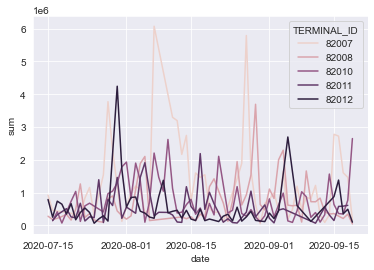

In [214]:
sns.set_style("darkgrid")
sns.lineplot(data=df[df['TERMINAL_ID'] >= 82007], x='date', y = 'sum', hue='TERMINAL_ID')

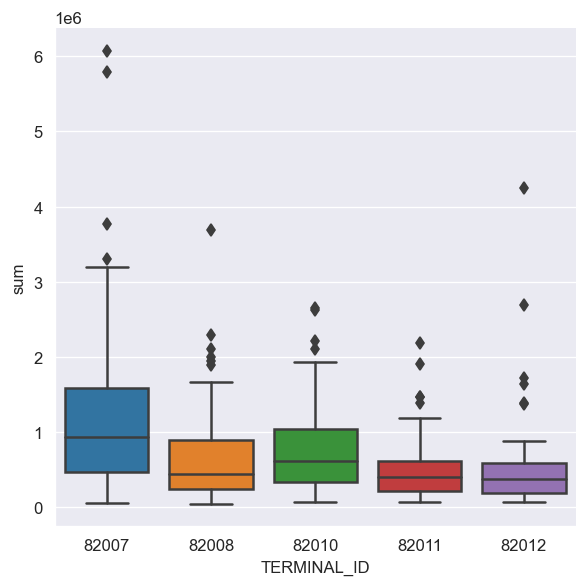

In [396]:
sns.catplot(data=df[df['TERMINAL_ID'] >= 82007], x="TERMINAL_ID", y="sum", kind="box")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

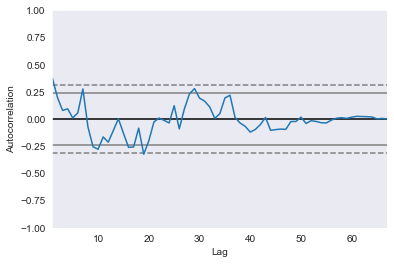

In [311]:
autocorrelation_plot(df[df['TERMINAL_ID'] == 11003][['date', 'sum']].set_index('date'))

In [666]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(df[df['TERMINAL_ID'] == 11003]['sum'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.024672
p-value                         0.032654
#Lags Used                      8.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


In [794]:
def get_terminal_data(terminal_id):
    global df
    dayli_sum_list = df[df['TERMINAL_ID'] == terminal_id][['sum', 'date']].set_index('date')
    mean = dayli_sum_list['sum'].mean()
    std = dayli_sum_list['sum'].std()
    dayli_sum_list['sum'] = (dayli_sum_list['sum'] - mean) / std
    
    diff_index_with_data_range = list(set(pd.date_range(min(dayli_sum_list.index), max(dayli_sum_list.index))) - set(dayli_sum_list.index))
    for date_index in diff_index_with_data_range:
        dayli_sum_list = dayli_sum_list.append(pd.DataFrame({'sum':[0], 'date': [date_index]}).set_index('date'))
    dayli_sum_list = dayli_sum_list.sort_index()
    
    q1 = dayli_sum_list['sum'].quantile(0.05)
    q3 = dayli_sum_list['sum'].quantile(0.95)
    iqr = q3 - q1
    dayli_sum_list.loc[(dayli_sum_list['sum'] < (q1 - iqr) ) \
                     & (dayli_sum_list['sum'] > (q3 + iqr) )] = 0
    return dayli_sum_list, mean, std

def predict_arima(terminal_data, start, end):
    model = ARIMA(terminal_data, order = (1, 0, 1), seasonal_order=(0, 1, 0, 30), freq='D')
    fit_model = model.fit()
    return fit_model.predict(start, end, typ='levels')

def predict_october_sum(terminal_id):
    terminal_data, mean, std = get_terminal_data(terminal_id)
    if(len(terminal_data) < 35): 
        return pd.DataFrame([])
    res = predict_arima(terminal_data, '2020-09-20', '2020-10-30')
    res_df = pd.DataFrame(res).reset_index()
    res_df['sum'] = ((res_df['predicted_mean'] * std) + mean).astype('int64')
    res_df.drop('predicted_mean', axis = 1, inplace=True)
    res_df.rename(columns={'index':'date'}, inplace=True)
    res_df['TERMINAL_ID'] = terminal_id
    return res_df

predict_df = pd.DataFrame();
for terminal_id in df['TERMINAL_ID'].unique():
    october_df = predict_october_sum(terminal_id)
    predict_df = predict_df.append(october_df)

In [795]:
predict_df

,date,sum,TERMINAL_ID
0,2020-09-20,4162382,11003
1,2020-09-21,406758,11003
2,2020-09-22,940849,11003
3,2020-09-23,1294330,11003
4,2020-09-24,242551,11003
...,...,...,...
36,2020-10-26,261497,82012
37,2020-10-27,431999,82012
38,2020-10-28,154999,82012
39,2020-10-29,9999,82012


# Блок 3. Формирование дэшборда

****
В приложении №2 представлены данные о простоях сети УС (время сколько устройства не были доступно клиенту). 

Формула расчета:

ОБСЛУЖИВАНИЕ УС ,ОТМ,FLM,SLM,Средства,АДМ,ИТ - Зоны

(ОБСЛУЖИВАНИЕ УС +ОТМ+FLM+SLM+Средства+АДМ+ИТ)= Простои

ФРВ – общий фонд работы устройства.
Доступность сети = Простои/ФРВ в процентах 

***

In [797]:
import pandas as pd
import plotly
df_graph = pd.read_excel('Приложение №2.xlsx')

,ДАТА,День,Месяц,Год,ТБ,Тип УС,ОТКРЫТ,ОБСЛУЖИВАНИЕ УС,ОТМ,FLM,SLM,Средства,АДМ,ИТ,ФРВ,Простой
0,2020-08-01,1,8,2020,Синий банк,ATM,129170,280,820,1940,1300,1960,850,660,136980,7810
1,2020-08-01,1,8,2020,Синий банк,ATM,354325,760,1640,2980,1155,4865,2805,80,368610,14285
2,2020-08-01,1,8,2020,Синий банк,ATM,112150,340,1210,1160,510,1120,4010,990,121490,9340
3,2020-08-01,1,8,2020,Синий банк,ATM,78060,120,260,210,0,90,60,0,78800,740
4,2020-08-01,1,8,2020,Синий банк,ITT,76990,50,360,710,0,190,1020,30,79350,2360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12395,2020-08-31,31,8,2020,Коричневый банк,RATM NCR,21235,20,50,0,295,0,0,0,21600,365
12396,2020-08-31,31,8,2020,Коричневый банк,ATM,289865,730,1360,1825,5275,2440,4735,1680,307910,18045
12397,2020-08-31,31,8,2020,Коричневый банк,ITT,138317,170,368,300,60,90,915,40,140260,1943
12398,2020-08-31,31,8,2020,Коричневый банк,RATM NAUTILUS,524350,900,2400,7970,3215,2610,4880,415,546740,22390


<span style='text-decoration: underline; font-size:18px; font-family: "Impact"'>Задача 1.1</span> 
##### Cформировать дэшборд для руководства. Необходимо видеть доступность сети и простои в разрезе зон с возможностью выбора банка и типа устройства.

In [ ]:
from dash import Dash, dcc, html, Input, Output
from dash.dependencies import Input, Output, State
import plotly.express as px
import pandas as pd

app = Dash(__name__)

app.layout = html.Div([
    html.H4('Простой по датам для выбранного банка'),
    dcc.Dropdown(
        id="dropdown",
        options=['Синий банк', 'Красный банк', 'Желтый банк', 'Черный банк', 'Оранжевый банк', 'Серый банк', 'Белый Банк', 'Зеленый банк','Коричневый банк', 'Золотой банк', 'Бронзовый банк'],
        value=['Зеленый банк'],
        multi=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(BankList):
    global df_graph
#     df_graph = pd.read_excel('Приложение №2.xlsx')
    fig = px.scatter(df_graph[df_graph['ТБ'].isin(BankList)], x="ДАТА", y="Простой", color = 'ТБ',
                    color_discrete_sequence=["blue", "red", "yellow", "black", "orange", "gray", "white", "green", "brown", "goldenrod", "#cd7f32"],
                    category_orders={"ТБ": ['Синий банк', 'Красный банк', 'Желтый банк', 'Черный банк', 'Оранжевый банк', 'Серый банк', 'Белый Банк', 'Зеленый банк','Коричневый банк', 'Золотой банк', 'Бронзовый банк']})
    fig.update_layout(showlegend=False)
    return fig


app.run_server(debug=True, use_reloader=False)